## This notebook builds a probabilistic model with Pymc3 to extend the MSqRob ridge regression model
https://www.ncbi.nlm.nih.gov/pubmed/28391044
$$
y_{ijkl} = \beta_{ij}^{treatment} + \beta_{ik}^{peptide} + \beta_{il}^{run} + \epsilon_{in}
$$

where $y$ stands for the $log_2$-transformed intensity of each peptide $k$ in run $l$ and condition $j$ that belong to protein $i$. $n$ is the $n^{th}$ peptide and $\epsilon$ is an noise term following a normal distribution with $mu$ = 0 and sigma $\sigma_i$ specific to the protein.
Each $\beta$ models a different effect on the final intensity measurement. The treatment effect \beta^{treatment} can be regarded as an estimate of the $\log_2$ protein quantity. Thus, $\beta_{ij}^{treatment A} - \beta_{ij}^{treatment B}$ is an estimate of the $log_2$ fold change of protein $i$ between conditions A and B.

Independent ridge regression models are built for all N peptides under protein $i$.

In this notebook, the fold change of the proteins detected in the MaxLFQ proteomebenchmark dataset: https://www.ebi.ac.uk/pride/archive/projects/PXD000279 is modeled in a similar way with a new extension.

The peptides.txt file from MaxQuant was read in R and preprocessed with MSqRob preprocess_MaxQuant().

Sequence features are extracted from each peptide to better capture the sequence variability inherent to each peptide.
The sequence features were extracted using the protr package in R using extractAPAAC(), which yields a numeric vector of 32 features for each peptide, independent of length.
Additionally to these 3 features, the number of missed cleavages of the peptide, and an integer encoding the neighboring residues of the peptide in the protein were added to the features, giving 35 features in total.

The sequence features are used to model the peptide effect \beta_{ik}^{peptide}.

$$
\beta_{ik}^{peptide} = \theta * features_{ik}
$$

which multiplies the intensities $y$ in the ridge regression model above, rendering a new model:

$$
y_{ijkln} = \beta^{treatment}_{ij} \beta_{ik}^{peptide} + + \beta_{il}^{run} + \epsilon_{in}
$$


In [1]:
import pymc3 as pm
import theano

/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas as pd
import os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
np.random.seed(123)
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
# %load BayesQuant.py
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from theano import shared
import theano
import shutil
import os
from exp_annot_funcs import *
import sys
import pickle
from sklearn.decomposition import PCA 
import seaborn as sns


class BayesQuant:

    "Compile a BayesQuant model, load data into it and posterior distributions"

    def __init__(self, data=None, features=None, plot_dir="../../Report/plots", traces_dir="traces"):
        self.data = data
        self.features = features
        self.p = None
        self.trace = None
        self.pca = None
        self.plot_dir = plot_dir
        self.traces_dir = traces_dir 
        self.sequence = False

    def read_data(self, data_path="data/data.tsv", features_path="data/advanced_features.tsv"):
        data = pd.read_csv(data_path, sep = "\t")
        for c in data.columns[2:].values:
            data[c] = data[c].astype(theano.config.floatX)


        self.data = data
        self.data.shape[0]


        if features_path is not None:
            features = pd.read_csv(features_path, sep = "\t").iloc[:,1:]
            features=features.iloc[data.index,:]
            n_seq_feat = features.shape[1]
            n_prots = len(np.unique(data.protein))
            self.features = features

        return (self.data, self.features)




    def compile_model(self, n_peptides, hierarchical_center=False):


        if self.features is None:
             self.sequence=False
             n_features=0
        elif isinstance(self.features, pd.DataFrame):
             self.sequence = True
             n_features = self.features.shape[1]
             self.feats_sh  = shared(np.array([[0.,]*n_features,]*n_peptides))
        else:
             sys.exit("Please set features to either None or a pd.DataFrame")


        self.observed_sh  = shared(np.array([0.,]*6*n_peptides))
        self.x_treat_sh  = shared(np.array([[0.,]*2,]*6*n_peptides))
        self.x_pep_sh  = shared(np.array([[0.,]*n_peptides,]*6*n_peptides))
        self.x_run_sh  = shared(np.array([[0.,]*6,]*6*n_peptides))
        self.x_estimate_sh  = shared(np.array([[0.,]*2,]*1))
     
        # The number of proteins in this model is always one
        # i.e this model is fitted protein-wise
        n_prots = 1
        
    
        with pm.Model() as model:
               
            # Build a hyerarchical linear model of
            # log2(MS1 intensities) by accounting for:
    
                 # Peptide effect
                 # Run (batch) effect
                 # Treatment effect
                 # Remaining random effects
    
            # The difference in treatment effects is an estimate of the log2FC
    
    
            # Set a prior on the random effects
            #sigma = pm.HalfNormal('sigma', 1)
            # Set a prior on the intercept
            intercept = pm.Normal("intercept", mu=22, sd=1)
            
    
            ## Set priors on the peptide effect
            ################################################
            sigma_pep = pm.HalfNormal('sigma_pep', 1)
    
            # Not using the sequence
            if not self.sequence:
                mu_pep = pm.Normal('mu_pep', mu=0, sd=sigma_pep)
    
            # Using the peptide sequence
            else: 
                # sequence based modelling
                sigma_theta = pm.HalfNormal('sigma_theta', sd=1)
                theta = pm.Normal('theta', mu=0, sd=sigma_theta, shape = (n_features, 1))
                theta_inter = pm.Normal('theta_inter', mu=0, sd=sigma_theta)
                mu_pep = pm.Normal("mu_pep", mu=theta_inter + pm.math.sum(self.feats_sh.dot(theta)), sd=sigma_pep)
    
    
            ## Set priors on the treatment and run effects
            ################################################    
            sigma_treat = pm.HalfNormal('sigma_treat', 1)
            mu_treat = pm.Normal('mu_treat', 0, sigma_treat)
            sigma_run = pm.HalfNormal('sigma_run', 1)
            mu_run = pm.Normal('mu_run', 0, sigma_run)
    
            # Standard implementation of the hyerarchies
            if hierarchical_center:
                pep = pm.Normal("pep", mu_pep, sigma_pep, shape = (n_peptides, 1)) # n_peptidesx1
                treat = pm.Normal('treat', mu_treat, sigma_treat, shape = (n_prots*2, 1))
                run = pm.Normal('run', mu_run, sigma_run, shape = (n_prots*6, 1))
    
            # Reparametrization to escape funnel of hell as noted in
            # http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/
            else:
                pep_offset = pm.Normal("pep_offset", mu=0, sd=1, shape = (n_peptides, 1))
                pep = pm.Deterministic("pep", mu_pep + pep_offset * sigma_pep)
                treat_offset = pm.Normal("treat_offset", mu=0, sd=1, shape=(n_prots*2, 1))
                treat = pm.Deterministic("treat", mu_treat + treat_offset*sigma_treat)
                run_offset = pm.Normal("run_offset", mu=0, sd=1, shape=(n_prots*6, 1))
                run = pm.Deterministic("run", mu_run + run_offset*sigma_run)
    
    
            # Model the effect for all peptides
            # The sh variables consist of -1,0,1 matrices telling pymc3
            # which parameters shall be used with each peptide
            # In practice, the "clone" each parameter to fit the shape of observed_sh
            # observed_sh is a n_peptides*6x1 tensor
            # The first 6 numbers store the MS1 intensities of the first peptide in the 6 runs
            # The next 6 those of the second peptide, and so on
    
            #estimate = pm.Deterministic('estimate', pm.math.sum(self.x_estimate_sh.dot(treat), axis=1))
            estimate = pm.Deterministic('estimate', self.x_estimate_sh.dot(treat))
            treatment_effect = pm.Deterministic("treatment_effect", pm.math.sum(self.x_treat_sh.dot(treat), axis=1))
            peptide_effect = pm.Deterministic("peptide_effect", pm.math.sum(self.x_pep_sh.dot(pep), axis=1))
            run_effect = pm.Deterministic("run_effect", pm.math.sum(self.x_run_sh.dot(run), axis=1))
    
            # BIND MODEL TO DATA
            mu = intercept + treatment_effect + peptide_effect + run_effect
            #mu = pm.Deterministic("mu", effects) #n_peptides*6x1
            epsilon = pm.HalfNormal('epsilon', sd=1)
            if hierarchical_center:
                obs = pm.Normal("obs", mu, epsilon, observed=self.observed_sh)
            else:
                obs_offset = pm.Normal("obs_offset", mu=0, sd=1, shape=(n_peptides*6,1))
                obs = pm.Normal("obs", mu+obs_offset*epsilon, epsilon, observed=self.observed_sh)
    
    
        print("Success: Model compiled")

        self.model = model
        return model
    
    def sample(self, model_name=None, n_draws=1000, n_chains=3, remove_backend=True):

        p = self.p
        if model_name is not None:
            p = model_name    

        # Check working environment  
        if not os.path.isdir(self.traces_dir) or not os.path.isdir(os.path.join(self.plot_dir, "traceplots")):
            msg = "Please create a traces dir and a traceplots dir before running this code"
            raise Exception(msg)
    
        if remove_backend and os.path.isdir("traces/{}".format(self.p)):
            shutil.rmtree("{}/{}".format(self.traces_dir, self.p))
    
    
        with self.model:
            # Parameters of the simulation:
            # Number of iterations and independent chains.
            n_sim = n_draws*n_chains
    
            # Save traces to the Text backend i.e a folder called
            # model_name containing csv files for each chain
            trace_name = '{}/{}'.format(self.traces_dir, self.p)
            db = pm.backends.Text(trace_name)
            trace = pm.sample(draws=n_draws, njobs=n_chains, trace=db,
                              tune=2000, nuts_kwargs=dict(target_accept=.95))
        


        self.trace = trace
           
        return trace

    def fit(self, model_name=None, n_iter=40000):

        p = self.p
        if model_name is not None:
            p = model_name
 
        try:
            os.mkdir("{}/{}".format(self.traces_dir, self.p))
        except:
            print("Dir exists")


        with self.model:
            
            advi = pm.ADVI()
            # how can the trace be saved when using pm.fit??
            #approx = advi.fit(n=n_draws, callbacks=[tracker])
            approx = advi.fit(n=n_iter)

            plt.plot(advi.hist)
            plt.legend()
            plt.title('ELBO')
            plt.xlabel('Iteration');
            plt.savefig(os.path.join(self.plot_dir, "ELBO/{}.eps".format(self.p)), format="eps", dpi=900)
            plt.close()

            trace=approx.sample(10000)

            with open("{}/{}/trace.pik".format(self.traces_dir, self.p), 'wb') as f:
                pickle.dump({'model': self.model, 'trace': trace}, f)

            #with open('trace.p', 'rb') as f:
            #    test1 = pickle.load(f)

        df=pd.DataFrame({"estimate": trace["estimate"][:,0,0]})
        df.to_csv("{}/{}/chain-0.tsv".format(self.traces_dir, self.p))

        self.trace = trace
        
        return trace
    
    def load_data(self, p, top=10):
    
        df = pd.DataFrame({"std": np.std(self.data.loc[self.data.protein == p,:].iloc[:,2:5].values, axis=1) + np.std(self.data.loc[self.data.protein == p,:].iloc[:,5:8].values, axis=1)})
        best_data = self.data.loc[self.data.protein == p,:].iloc[df.sort_values(by="std", ascending=True).iloc[:top,:].index,:]
        variables = create_variables(best_data, self.features, [p])
        observed, feats, x_treat, x_pep, x_run, x_estimate = variables

        self.observed_sh.set_value(observed)
        if feats is not None:
            self.feats_sh.set_value(feats)    

        self.x_treat_sh.set_value(x_treat)
        self.x_pep_sh.set_value(x_pep)
        self.x_run_sh.set_value(x_run)
        self.x_estimate_sh.set_value(x_estimate)
        self.p = p
        self.n_peptides = top 


    def ppc(self, samples=500, suffix=""):

        with self.model:
            sim = pm.sample_ppc(self.trace, samples=samples)["obs"]

        sim=sim[:,0,:]
        peps = list(map(lambda i: sim[:, (i*6):((i*6)+6)], range(self.n_peptides)))
        estimates = list(map(lambda x: np.mean(x[:,:3], axis=1) - np.mean(x[:,3:6], axis=1), peps))
        fig, ax = plt.subplots(1,self.n_peptides, figsize=(15,5))
        [ax[i].hist(e) for i, e in enumerate(estimates)]
        [ax[i].set_xlabel("log2FC") for i, e in enumerate(estimates)]
        [ax[i].set_title("Peptide {}".format(i+1)) for i, e in enumerate(estimates)]
        
        plt.savefig(os.path.join(self.plot_dir, "PPC", "eps", "histogram_{}.eps".format(self.p)), format="eps", dpi=900)
        plt.close()

        peps_data = np.vstack(peps)
        sim_transformed = self.pca.transform(peps_data)
        obs = self.data.loc[self.data.protein == p].iloc[:,2:]
        obs_transformed = self.pca.transform(obs)

        plt.scatter(sim_transformed[:,0], sim_transformed[:,1], c = "#4C2D73", label="Sim obs")
        plt.scatter(obs_transformed[:,0], obs_transformed[:,1], c = "#AAA039", label="True obs")
        plt.legend()
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.savefig(os.path.join(self.plot_dir, "PPC", "eps", "PCA_{}{}.eps".format(self.p, suffix)), format="eps", dpi=900)
        plt.close()

    def PCA(self, filename="PCA", facet=True):
        x = self.data.values[:,2:]
        pca = PCA(n_components=2)
        pca.fit(x)
        self.pca = pca
        print("Percentage of variance explained by PC1 and PC2")
        print(pca.explained_variance_ratio_*100)
        x_transformed = pca.transform(x)
        if not facet:
            pca_data = pd.DataFrame({"PC1": x_transformed[:,0], "PC2": x_transformed[:,1]})
            myPlot = plt.scatter(pca_data["PC1"], pca_data["PC2"], s=5, alpha=0.3)
            plt.savefig(os.path.join(self.plot_dir, filename+".eps"), format="eps", dpi=900)
            plt.savefig(os.path.join(self.plot_dir, filename+".png"))
            plt.close()

        else:
            pca_data = pd.DataFrame({"taxon": self.data.taxon, "PC1": x_transformed[:,0], "PC2": x_transformed[:,1]})
            myPlot = sns.FacetGrid(col="taxon", hue='taxon', data=pca_data, size=5)
            myPlot = myPlot.map(plt.scatter, "PC1", "PC2", alpha=0.3)
            myPlot = myPlot.map_dataframe(plt.plot, [min(pca_data.PC1),max(pca_data.PC1)], [0, 0], 'r-').add_legend().set_axis_labels("PC1", "PC2")
            plt.savefig(os.path.join(self.plot_dir, filename+".eps"), format="eps", dpi=900)
            plt.savefig(os.path.join(self.plot_dir, filename+".png"))
            plt.close()
            plt.close()

    def plot_posterior(self, varnames=["estimate"], ref_val=np.log2(3), color="LightSeaGreen", rope=[-.4, .4], xlim=[-.5,2], suffix=""):
        plt.rcParams.update({'font.size': 15, 'figure.figsize': (7,5)})
        pm.plot_posterior(self.trace, varnames=varnames, ref_val=ref_val, color=color, rope=rope)
        plt.title("log2FC Posterior for {}".format(self.p.split(";")[0]))
        plt.xlim(xlim)
        plt.ylabel("Probability")
        plt.savefig(os.path.join(self.plot_dir, "posteriors", "eps", "{}{}.eps".format(self.p, suffix)), format='eps', dpi=900)
        plt.savefig(os.path.join(self.plot_dir, "posteriors", "png", "{}{}.png".format(self.p, suffix)))
        plt.close()


    def traceplot(self, varnames=["estimate", "pep", "run"], suffix=""):
        plt.rcParams.update({'font.size': 15, 'figure.figsize': (6,11)})
        pm.traceplot(self.trace, varnames=varnames)
        plt.savefig(os.path.join(self.plot_dir, "traceplots", "eps", "{}{}.eps".format(self.p, suffix)), format='eps', dpi=900)
        plt.savefig(os.path.join(self.plot_dir, "traceplots", "png", "{}{}.png".format(self.p, suffix)))
        plt.close()




/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# from numpy.linalg import norm
# p1 = np.array([0,0])
# p2 = np.array([1,1])
# indices = [bayesquant.data.taxon == "Homo sapiens", bayesquant.data.taxon != "Homo sapiens"]
# print(indices)
# hsapiens_d, ecoli_d =np.array([[norm(np.cross(p2-p1, p1-p3))/norm(p2-p1) for p3 in zip(x[idx],y[idx])] for idx in indices])
# print(np.mean(hsapiens_d))
# print(np.mean(ecoli_d))

In [6]:
bayesquant = BayesQuant()
data,_ = bayesquant.read_data(data_path="data/ms1_intensities.tsv", features_path=None)
n_peptides=3
bayesquant.compile_model(n_peptides=n_peptides)

Success: Model compiled


### Every protein has at least two peptides

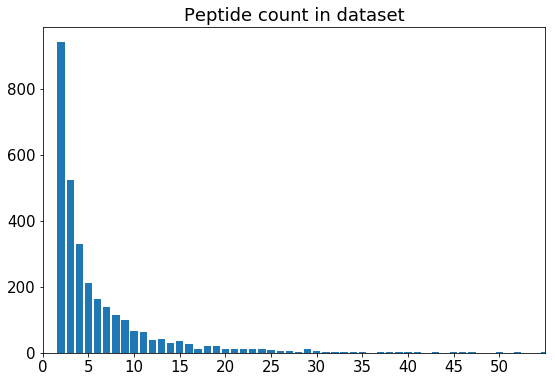

In [6]:
counts0 = np.unique(bayesquant.data.protein, return_counts=True)
counts = np.unique(counts0[1], return_counts=True)
counts_df = pd.DataFrame(np.array([counts[0], counts[1]]).T, columns = ["n_peptides", "n_prots"])
plt.rcParams.update({'font.size': 15, 'figure.figsize': (9,6)})
plt.bar(x=counts_df.n_peptides, height=counts_df.n_prots)
plt.title("Peptide count in dataset")
plt.xticks(range(0,55, 5))
plt.xlim([0, 55])
plt.savefig("../../Report/plots/peptide_counts.eps", format='eps', dpi=900, height=12, width=7)

In [7]:
report_sample_data1 = bayesquant.data.loc[bayesquant.data.protein == "P0A8I8",:]
report_sample_data1.taxon = "E. coli"
report_sample_data2 = bayesquant.data.loc[bayesquant.data.protein == "A6NDG6",:]
report_sample_data = pd.concat([report_sample_data1, report_sample_data2])
report_sample_data.iloc[:,2:]=np.round(report_sample_data.iloc[:,2:], decimals=2)
colnames = report_sample_data.columns.values
colnames[colnames == "taxon"] = "Organism"
report_sample_data.columns = colnames
print(report_sample_data.to_latex(escape=False, index=None))

\begin{tabular}{llrrrrrr}
\toprule
protein &      Organism &     H1 &     H2 &     H3 &     L1 &     L2 &     L3 \\
\midrule
 P0A8I8 &       E. coli &  25.13 &  25.24 &  24.39 &  21.71 &  22.67 &  22.40 \\
 P0A8I8 &       E. coli &  21.49 &  23.10 &  23.38 &  21.34 &  22.65 &  21.25 \\
 P0A8I8 &       E. coli &  24.10 &  24.54 &  23.81 &  19.88 &  20.87 &  20.30 \\
 A6NDG6 &  Homo sapiens &  25.08 &  24.98 &  23.83 &  22.54 &  22.52 &  24.96 \\
 A6NDG6 &  Homo sapiens &  22.70 &  24.32 &  23.00 &  22.29 &  23.27 &  23.91 \\
 A6NDG6 &  Homo sapiens &  21.18 &  22.51 &  23.25 &  22.30 &  21.75 &  23.61 \\
\bottomrule
\end{tabular}



/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
p = "A6NDG6"
bayesquant.load_data(p, top=n_peptides)
trace_human = bayesquant.fit(model_name=p, n_iter=40000)
bayesquant.PCA()
bayesquant.ppc()
bayesquant.traceplot()
bayesquant.plot_posterior()

3it [00:00, 13217.34it/s]


Shape of x_treat is 18, 2
Shape of x_pep is 18, 3
Shape of x_estimate is 1, 2
Dir exists


Average Loss = 365.15: 100%|██████████| 40000/40000 [00:26<00:00, 1531.24it/s]
Finished [100%]: Average Loss = 365.13
No handles with labels found to put in legend.


In [9]:
p = "P0A8I8"
bayesquant.load_data(p, top=n_peptides)
trace_ecoli = bayesquant.fit(model_name=p, n_iter=40000)
bayesquant.PCA()
bayesquant.ppc()
bayesquant.traceplot()
bayesquant.plot_posterior()

3it [00:00, 11640.07it/s]


Shape of x_treat is 18, 2
Shape of x_pep is 18, 3
Shape of x_estimate is 1, 2
Dir exists


Average Loss = 420.08: 100%|██████████| 40000/40000 [00:28<00:00, 1388.77it/s]
Finished [100%]: Average Loss = 420.07
No handles with labels found to put in legend.


Percentage of variance explained by PC1 and PC2
[84.62583393  8.76137261]


100%|██████████| 500/500 [00:00<00:00, 1468.27it/s]
